In [154]:
### data and matrix handling
import pandas as pd
import numpy as np

## visualization
import matplotlib.pyplot as plt
import seaborn as sns

## scientific
import scipy

## utilities
import os

In [155]:
## loading the data
data_path = "x__data/"
math_path = os.path.join(data_path, "student_math_clean.csv")
portuguese_path = os.path.join(data_path, "student_portuguese_clean.csv")

math_df = pd.read_csv(math_path)
portuguese_df = pd.read_csv(portuguese_path)

## Data formatting for database

### function for formatting data

In [156]:
def format_data(math_df, portuguese_df):
    ## creating new feature for whether subject is math intensive
    new_feature_name = "math_intensive"
    portuguese_df[new_feature_name] = "no"
    math_df[new_feature_name] = "yes"

    ## creating feature for subject
    # new_feature_name = "subject"
    # portuguese_df[new_feature_name] = "Language"
    # math_df[new_feature_name] = "Core Mathematics"
    
    ## getting all portuguese students who also did math
    # portuguese_df = portuguese_df[portuguese_df.student_id.isin(math_df.student_id.values)]
    
    ## putting the data together
    df = pd.concat([portuguese_df, math_df], axis=0)
    df["final_grade"] = df["final_grade"]/20 * 100
    df["grade_1"] = df["grade_1"]/20 * 100
    df["grade_2"] = df["grade_2"]/20 * 100

    ## dropping unnecessary features

    maps = {
        "sex": {"M": "male", "F": "female"},
        "address_type": lambda x : x.lower(),
        "parent_status": {"Living together": "together", "Apart": "apart"},
        "mother_education": {"primary education (4th grade)": "primary",
                             "5th to 9th grade": "middle",
                             "secondary education": "secondary",
                             "higher education" :"higher",
                             "none" : "none"
                            },
        "father_education": {"primary education (4th grade)": "primary",
                             "5th to 9th grade": "middle",
                             "secondary education": "secondary",
                             "higher education" :"higher",
                             "none" : "none"
                            },
        "mother_job": {"teacher": "education",
                        "services": "civil",
                        "at_home": "unemployed",
                       "health": "health",
                       "other": "other"
                      },
        "father_job": {"teacher": "education",
                        "services": "civil",
                        "at_home": "unemployed",
                       "health": "health",
                       "other": "other"
                      },
        "travel_time": {"<15 min.": "less_than_15",
                       "15 to 30 min.": "within_15_and_30",
                       "30 min. to 1 hour": "within_30_and_hour",
                       ">1 hour": "greater_than_hour"},
        "study_time": {"<2 hours": "less_than_2_hours",
                       "2 to 5 hours": "within_2_and_5_hours",
                       "5 to 10 hours": "within_5_and_10_hours",
                       ">10 hours": "greater_than_10_hours"},
        "family_size": lambda x : "_".join(x.strip().lower().split())
    }

    for k, v in maps.items():
        df[k] = df[k].map(v)

    booleans = ["romantic_relationship", "internet_access", "higher_ed", "activities",
                "extra_paid_classes", "family_support", "school_support", "math_intensive",
                "nursery_school"
               ]

    for col in booleans:
        df[col] = df[col].map({"yes": 1, "no":0})

    column_renames = {"sex": "gender", "grade_2": "previous_grade"}
    df = df.rename(columns=column_renames)

    ## dropping some columns
    cols_to_drop = ["school", "weekend_alcohol", "weekday_alcohol", "health", "student_id"]
    df = df.drop(cols_to_drop, axis = 1)
            
    return df


In [157]:
student_df = format_data(math_df, portuguese_df)

## Separating into `categorical` and `numerical` features

In [158]:
cat_df = student_df.select_dtypes(["object","bool"])
num_df = student_df.select_dtypes("number")

In [159]:
print(f"There are {cat_df.shape[1]} categorical features and {num_df.shape[1]} numerical features")

There are 12 categorical features and 18 numerical features


## Preparing for prediction

In [160]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Separating into predictors and target

In [161]:
X = student_df.drop(["final_grade", "grade_1"], axis=1)
y = student_df["final_grade"]

### Splitting data into train and test

#### Getting student ids for training data

In [162]:
ts = 0.05
rs = 42
# ids = X["student_id"]

# test_ids = ids.sample(frac=ts, random_state=rs).unique()
# len(test_ids)

In [163]:
# X_train = X[~student_df["student_id"].isin(test_ids)]
# y_train = student_df[~student_df["student_id"].isin(test_ids)]["final_grade"]

# X_test = X[student_df["student_id"].isin(test_ids)]
# y_test = student_df[student_df["student_id"].isin(test_ids)]["final_grade"]

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)

In [165]:
ignores = ["final_grade", "grade_1", "student_id", "subject"]

cat_cols = student_df.select_dtypes(["object","bool"]).columns
cat_cols = [col for col in cat_cols if col not in ignores]

num_cols = student_df.select_dtypes("number")
num_cols = [col for col in num_cols if col not in ignores]

### `Preprocessing Pipeline`

In [166]:
## getting numerical and categorical features
numerical_features = num_cols
categorical_features = cat_cols

## transformer for numeric features
numeric_transformer = Pipeline(steps = [("scaler", StandardScaler())])

## transformer for categorical features
categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder())])


## preprocessor)
preprocessor = ColumnTransformer(
    transformers = [
        ("numerical", numeric_transformer, numerical_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

In [167]:
X_train.columns

Index(['gender', 'age', 'address_type', 'family_size', 'parent_status',
       'mother_education', 'father_education', 'mother_job', 'father_job',
       'school_choice_reason', 'guardian', 'travel_time', 'study_time',
       'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'absences', 'previous_grade', 'math_intensive'],
      dtype='object')

### Preprocessing

In [168]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'class_failures', 'school_support',
                                  'family_support', 'extra_paid_classes',
                                  'activities', 'nursery_school', 'higher_ed',
                                  'internet_access', 'romantic_relationship',
                                  'family_relationship', 'free_time', 'social',
                                  'absences', 'previous_grade',
                                  'math_intensive']),
                                ('categorical',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['gender', 'address_type', 'family_size',
                                  'parent_status', 'mother_education',
                                  'father_education', 'mother_job',
                                  'father_job', 'school_choice_reason',
                                  'guardian', 'travel_time', 'study_time'])])

In [169]:
X_train = preprocessor.transform(X_train)

## Training

In [170]:
## models 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## hyperparameter selection
from sklearn.model_selection import GridSearchCV, KFold

## metrics
from sklearn.metrics import r2_score

### Grid Search

In [171]:
## folds
kf = KFold(n_splits=7, shuffle=True, random_state=42)

In [172]:
## function for grid_search
def grid_search(estimator, params, X, y, verbose=0):
    global kf
    grid = GridSearchCV(estimator, params, cv=kf, scoring="r2", verbose=verbose)
    grid.fit(X, y)

    print(f"Best score: {grid.best_score_}")
    print(f"Best parameters: {grid.best_params_}")

    return grid.best_score_, grid.best_params_, grid.best_estimator_

#### Decision Tree Regressor

In [173]:
params = {
    "max_depth": [2,4,6,8]
}

grid_search(DecisionTreeRegressor(), params, X_train, y_train)

Best score: 0.8370313259299582
Best parameters: {'max_depth': 4}


(0.8370313259299582, {'max_depth': 4}, DecisionTreeRegressor(max_depth=4))

#### SVR

In [49]:
params = {
    "C": [0.5, 1, 1.3]
}

grid_search(SVR(), params, X_train, y_train)

Best score: 0.7515412397893215
Best parameters: {'C': 1.3}


AttributeError: 'GridSearchCV' object has no attribute 'best_score'

#### Random Forest Regressor

In [52]:
params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [4,6,8, 10]
}

_, _, estimator = grid_search(RandomForestRegressor(), params, X_train, y_train, verbose=10)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV 1/7; 1/12] START max_depth=4, n_estimators=100..............................
[CV 1/7; 1/12] END max_depth=4, n_estimators=100;, score=0.837 total time=   0.3s
[CV 2/7; 1/12] START max_depth=4, n_estimators=100..............................
[CV 2/7; 1/12] END max_depth=4, n_estimators=100;, score=0.838 total time=   0.3s
[CV 3/7; 1/12] START max_depth=4, n_estimators=100..............................
[CV 3/7; 1/12] END max_depth=4, n_estimators=100;, score=0.916 total time=   0.3s
[CV 4/7; 1/12] START max_depth=4, n_estimators=100..............................
[CV 4/7; 1/12] END max_depth=4, n_estimators=100;, score=0.816 total time=   0.3s
[CV 5/7; 1/12] START max_depth=4, n_estimators=100..............................
[CV 5/7; 1/12] END max_depth=4, n_estimators=100;, score=0.849 total time=   0.5s
[CV 6/7; 1/12] START max_depth=4, n_estimators=100..............................
[CV 6/7; 1/12] END max_depth=4, n_estimator

#### Gradient Boosting Regressor

In [124]:
params = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [2,4,6,8],
    "learning_rate": [0.1, 0.3, 1]
}

grid_search(GradientBoostingRegressor(), params, X_train, y_train, verbose=10)

Fitting 7 folds for each of 36 candidates, totalling 252 fits
[CV 1/7; 1/36] START learning_rate=0.1, max_depth=2, n_estimators=300...........
[CV 1/7; 1/36] END learning_rate=0.1, max_depth=2, n_estimators=300;, score=0.325 total time=   0.9s
[CV 2/7; 1/36] START learning_rate=0.1, max_depth=2, n_estimators=300...........
[CV 2/7; 1/36] END learning_rate=0.1, max_depth=2, n_estimators=300;, score=0.422 total time=   0.8s
[CV 3/7; 1/36] START learning_rate=0.1, max_depth=2, n_estimators=300...........
[CV 3/7; 1/36] END learning_rate=0.1, max_depth=2, n_estimators=300;, score=0.252 total time=   1.0s
[CV 4/7; 1/36] START learning_rate=0.1, max_depth=2, n_estimators=300...........
[CV 4/7; 1/36] END learning_rate=0.1, max_depth=2, n_estimators=300;, score=0.263 total time=   1.0s
[CV 5/7; 1/36] START learning_rate=0.1, max_depth=2, n_estimators=300...........
[CV 5/7; 1/36] END learning_rate=0.1, max_depth=2, n_estimators=300;, score=0.406 total time=   0.9s
[CV 6/7; 1/36] START learnin

GradientBoostingRegressor(max_depth=2, n_estimators=300)

#### LGBMRegressor

In [67]:
params = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [2,4,6,8],
    "learning_rate": [0.1, 0.3, 1]
}

bs, bp, _ = grid_search(LGBMRegressor(verbose=0), params, X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [69]:
# bp

NameError: name 'bp' is not defined

### Training Models

#### Linear Regression

In [89]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [90]:
print(r2_score(lr.predict(X_test), y_test))

-1.5003242132110124


## Model interpretation

In [144]:
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
import lime.lime_tabular

### Fitting selected model

In [145]:
estimator = RandomForestRegressor(**{'max_depth': 4, 'n_estimators': 300})
estimator.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=300)

### Checking performance of model on testing data

In [146]:
print(r2_score(y_test, estimator.predict(preprocessor.transform(X_test))))

0.8919641961983693


### Getting feature importances

In [106]:
feature_importances = permutation_importance(estimator=estimator, X=X_train, y=y_train, n_repeats=10, random_state=42)

In [107]:
## sorting from most important to least important
sorted_idxs = feature_importances.importances_mean.argsort()

#### Getting top features

In [108]:
top_idxs = sorted_idxs[-12:][::-1]
top_features = preprocessor.get_feature_names_out()[top_idxs]
top_scores = feature_importances.importances_mean[top_idxs]

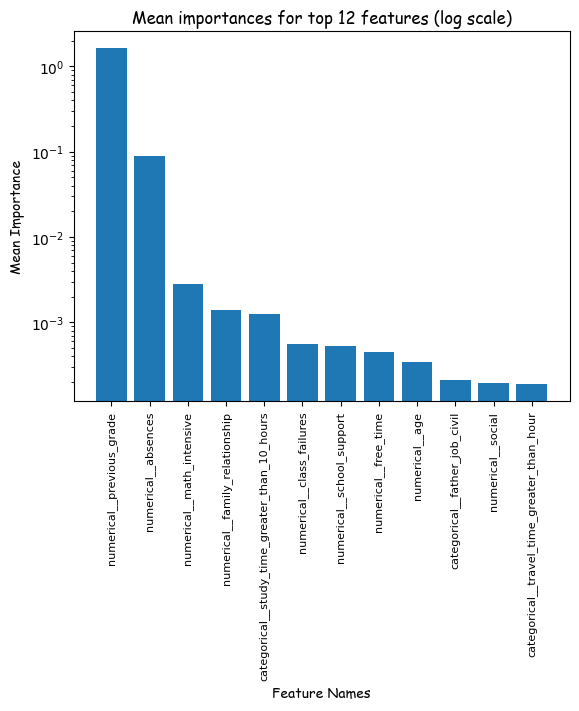

In [109]:
## displaying top 10 features
plt.bar(top_features, top_scores, log=True, animated=True)

## presets
plt.xticks(rotation=90, fontsize=8)
csfont = {'fontname':'Comic Sans MS'}
label_font = {"fontname": "cursive", "fontsize": 10}
plt.title(f"Mean importances for top {len(top_features)} features (log scale)",**csfont)


plt.xlabel('Feature Names', **label_font)
plt.ylabel("Mean Importance", **label_font)

plt.show()

#### Partial dependence for top features

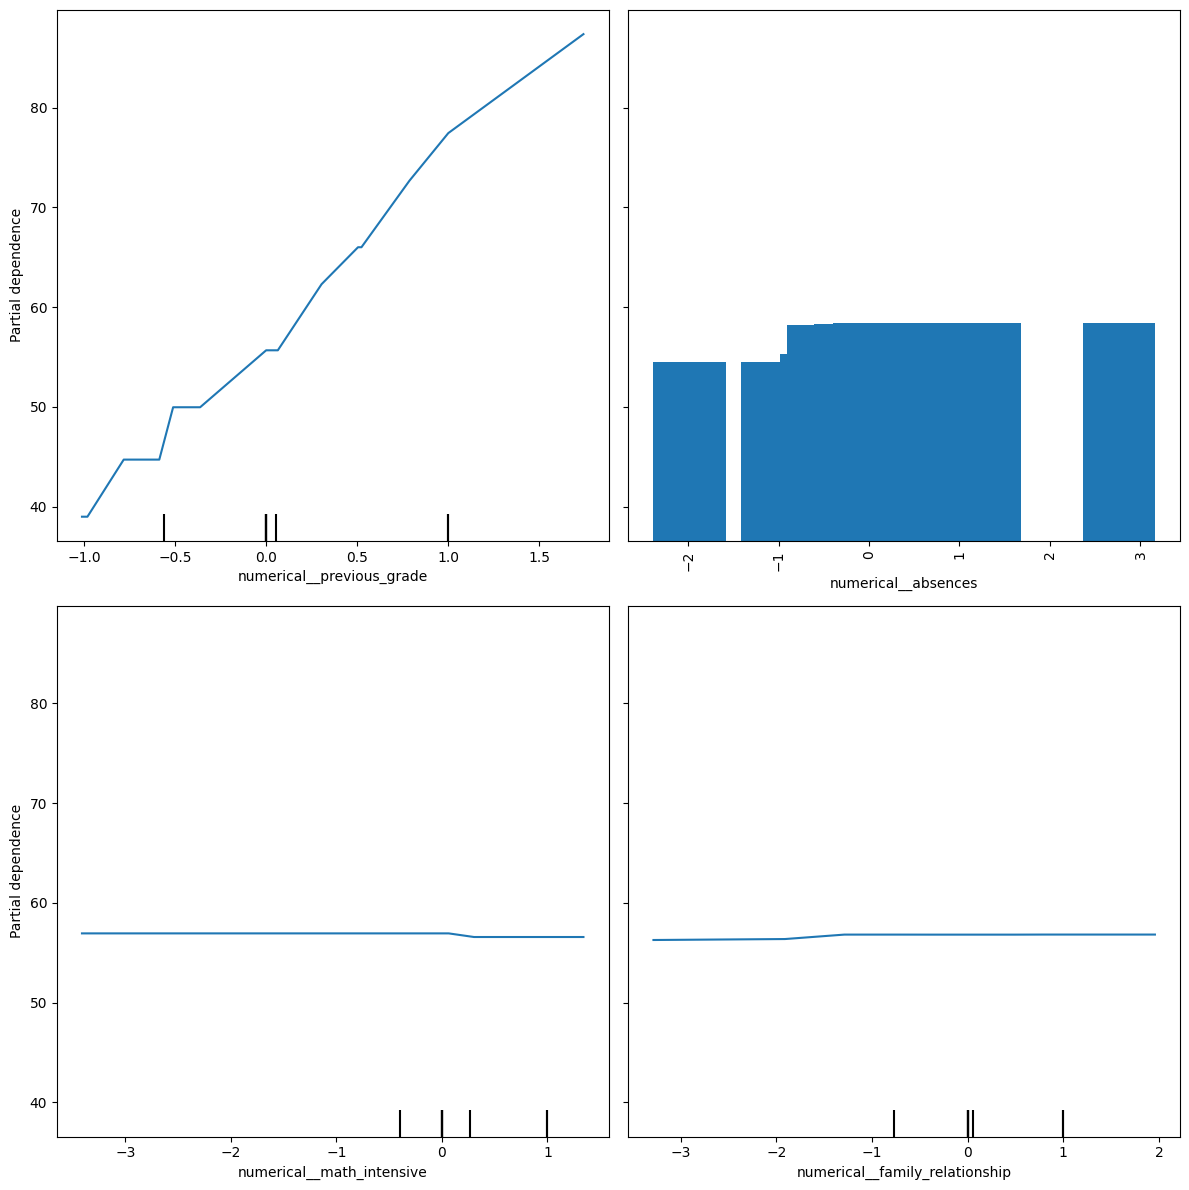

In [110]:
fig, axes = plt.subplots(2,2,figsize=(12,12))

PartialDependenceDisplay.from_estimator(
    estimator=estimator,
    X=X_train.T,
    features=top_idxs[:4],
    categorical_features=[top_idxs[1]],
    random_state=42,
    feature_names = preprocessor.get_feature_names_out(),
    n_cols=4,
    ax=axes
)

plt.tight_layout()
plt.show()

In [111]:
top_features

array(['numerical__previous_grade', 'numerical__absences',
       'numerical__math_intensive', 'numerical__family_relationship',
       'categorical__study_time_greater_than_10_hours',
       'numerical__class_failures', 'numerical__school_support',
       'numerical__free_time', 'numerical__age',
       'categorical__father_job_civil', 'numerical__social',
       'categorical__travel_time_greater_than_hour'], dtype=object)

### Surrogate (Linear Regression)

In [112]:
## get black box predictions
y_blackbox = estimator.predict(preprocessor.transform(X_test))

## train surrogate
surrogate = Ridge(max_iter=10000, alpha=0.5)
surrogate.fit(preprocessor.transform(X_test), y_blackbox)

Ridge(alpha=0.5, max_iter=10000)

In [113]:
## check performance
r2_score(y_blackbox, surrogate.predict(preprocessor.transform(X_test)))

0.9920758301399585

In [114]:
surrogate.coef_

array([-0.45369247, -2.02371828, -2.40556392, -0.41595148,  0.85635649,
       -0.70632833, -2.49889665, -0.40815313, -1.33197521,  0.56906094,
       -1.27948118,  0.44552058,  0.41669808,  0.69888117, 16.30160073,
       -0.2825162 ,  0.36717251, -0.36717251, -1.84499586,  1.84499586,
       -1.11819295,  1.11819295,  1.10789015, -1.10789015,  1.57497471,
       -1.4747758 ,  0.        , -0.91822333,  0.81802442,  1.48408335,
       -1.6527208 , -0.27641474,  0.24689207,  0.19816012,  1.98160009,
       -4.45819155,  1.24641485,  0.37509777,  0.85507884,  3.01728179,
       -4.53516432, -1.78828444,  3.26546362,  0.04070335,  0.66724368,
        1.83778308,  0.39054217, -2.89556894,  1.18346969, -0.47331461,
       -0.71015508,  0.        , -1.09932213,  0.47238603,  0.62693611,
        0.44367594, -0.21795326, -1.90826114,  1.68253845])

<BarContainer object of 12 artists>

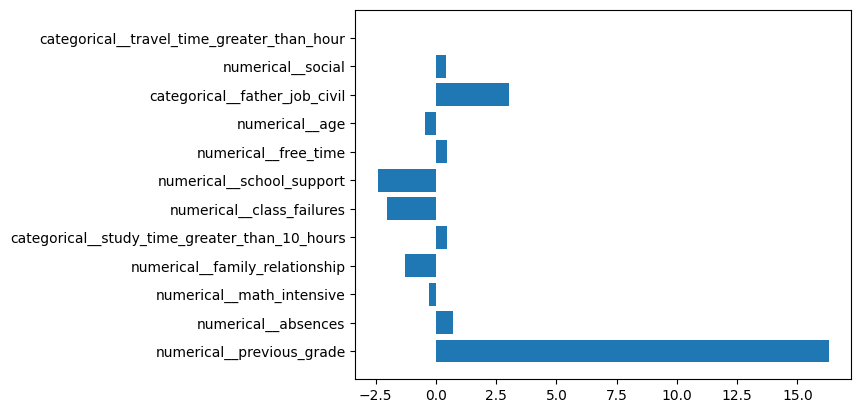

In [115]:
# fig = plt.figure(figsize=(12,12))
plt.barh(preprocessor.get_feature_names_out()[top_idxs],surrogate.coef_[top_idxs])

### **LIME** for random test sample

#### Creating explainer

In [116]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=preprocessor.transform(X_test),
    mode="regression",
    feature_names=preprocessor.get_feature_names_out(),
    random_state=42,
    verbose=True
)

In [117]:
instance_idx = np.random.randint(X_test.shape[0])
selected_instance = preprocessor.transform(X_test)[instance_idx]
pd.DataFrame(data=selected_instance.reshape(1,-1), columns=preprocessor.get_feature_names_out())[top_features]

numerical__previous_grade  numerical__absences  numerical__math_intensive  \
0                   0.225684             0.563759                  -0.781909   

   numerical__family_relationship  \
0                       -3.168503   

   categorical__study_time_greater_than_10_hours  numerical__class_failures  \
0                                            0.0                  -0.406471   

   numerical__school_support  numerical__free_time  numerical__age  \
0                  -0.362324             -1.175679        2.665587   

   categorical__father_job_civil  numerical__social  \
0                            0.0          -0.139789   

   categorical__travel_time_greater_than_hour  
0                                         0.0

In [118]:
estimator.predict(selected_instance.reshape(1,-1))

array([61.99582318])

Intercept 53.85281366041217
Prediction_local [66.41122262]
Right: 61.9958231751674


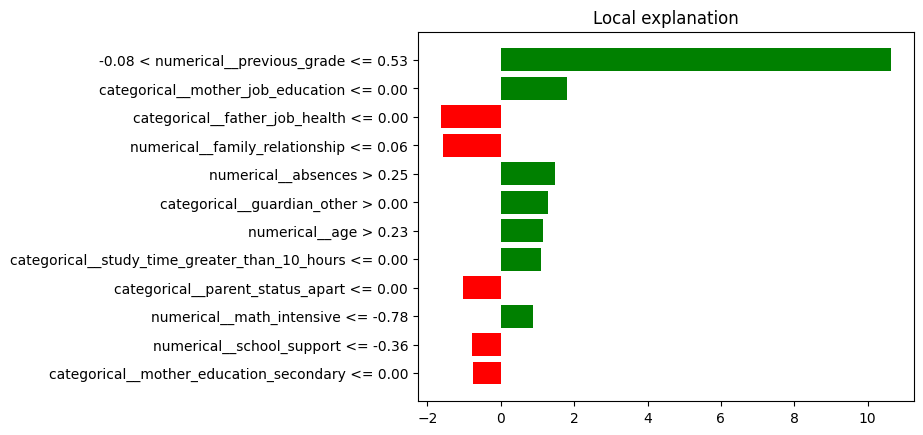

In [119]:
exp = explainer.explain_instance(selected_instance,
                                 estimator.predict,
                                 num_features=len(top_features)
                                )

exp.as_pyplot_figure()
plt.show()

## Saving Data

#### Addin necessary features

In [191]:
def add_features(df):
    df = df.copy()

    ## adding subjects feature
    df["subject"] = "language"
    df.loc[df["math_intensive"]==1, "course"] = "mathematics"

    ## adding course feature
    df["course"] = "general arts"
    df.loc[df["math_intensive"]==1, "course"] = "science"

    ## adding index
    start = 300000
    end=start+X_test.shape[0]
    index_numbers = list(range(start,end))
    df["index_number"] = index_numbers

    return df

In [192]:
add_features(X_test)

gender  age address_type              family_size parent_status  \
322  female   17        rural  less_than_or_equal_to_3      together   
280    male   18        rural  less_than_or_equal_to_3      together   
536    male   15        urban  less_than_or_equal_to_3         apart   
175    male   17        urban  less_than_or_equal_to_3      together   
644  female   19        rural           greater_than_3      together   
128    male   18        rural           greater_than_3      together   
329  female   17        urban           greater_than_3      together   
231    male   18        urban  less_than_or_equal_to_3      together   
11   female   15        urban           greater_than_3      together   
548  female   17        urban           greater_than_3         apart   
346    male   17        urban  less_than_or_equal_to_3      together   
168    male   15        rural           greater_than_3      together   
1    female   17        urban           greater_than_3      together   
125    male   15        urban           greater_than_3      together   
261  female   17        rural           greater_than_3      together   
361    male   19        urban           greater_than_3      together   
558    male   17        rural           greater_than_3      together   
245    male   16        urban           greater_than_3      together   
312  female   18        urban           greater_than_3      together   
55   female   16        urban           greater_than_3         apart   
26     male   15        urban           greater_than_3      together   
31     male   15        urban           greater_than_3      together   
330    male   18        urban  less_than_or_equal_to_3      together   
244  female   17        urban  less_than_or_equal_to_3      together   
158  female   15        urban           greater_than_3      together   
547    male   16        rural  less_than_or_equal_to_3      together   
265  female   17        rural  less_than_or_equal_to_3      together   
139  female   15        urban           greater_than_3      together   
288    male   18        urban           greater_than_3      together   
355  female   17        urban           greater_than_3      together   
302  female   17        urban           greater_than_3      together   
177    male   17        urban           greater_than_3      together   
635  female   17        rural           greater_than_3      together   
491  female   19        urban           greater_than_3      together   
638    male   17        urban           greater_than_3      together   
331    male   17        urban           greater_than_3      together   
96     male   16        rural           greater_than_3      together   
260  female   16        urban           greater_than_3      together   
522  female   16        urban           greater_than_3      together   
339  female   17        rural           greater_than_3         apart   
611  female   18        rural           greater_than_3      together   
101    male   16        urban           greater_than_3      together   
184  female   16        urban           greater_than_3      together   
388  female   18        urban           greater_than_3      together   
70     male   16        urban           greater_than_3      together   
43     male   15        urban           greater_than_3      together   
174    male   17        rural  less_than_or_equal_to_3      together   
59   female   16        urban           greater_than_3      together   
247    male   22        urban           greater_than_3      together   
76     male   15        urban           greater_than_3      together   
519    male   16        rural           greater_than_3      together   
299  female   20        rural           greater_than_3      together   
206  female   16        urban           greater_than_3         apart   

    mother_education father_education  mother_job  father_job  \
322           middle           middle       civil  

#### Adding additional features

In [193]:
X_test = add_features(X_test)

In [194]:
save_folder = "x__data/"
X_test.reset_index().to_json(os.path.join(save_folder, "database_data.json"), orient="records", index=False)

## Saving model

In [195]:
import pickle

In [196]:
save_folder = "x__models/"

In [197]:
# saving preprocessor
with open(os.path.join(save_folder, "student_data_preprocessor.pickle"), "wb") as file:
    pickle.dump(preprocessor, file)

## saving estimator
with open(os.path.join(save_folder, "grade_predictor.pickle"), "wb") as file:
    pickle.dump(estimator, file)